## Requirements

### Imports

In [22]:
import os
import torch
from pathlib import Path

import random
import torch
import torchcam
import matplotlib.pyplot as plt
import numpy as np
import cv2

from torchcam.methods import GradCAM
from torchvision import transforms

In [23]:
import training

In [24]:
torch.manual_seed(42)

### Paths

In [25]:
SRC_DIR = Path.cwd()
ROOT_DIR = SRC_DIR.parent

DATA_DIR = os.path.join(ROOT_DIR, 'dataset')
PREPROCESSED_DIR = os.path.join(DATA_DIR, 'preprocessed')
CSV_PATH = os.path.join(DATA_DIR, 'csv_mappings', 'train.csv')

MODEL_DIR = os.path.join(ROOT_DIR, 'models')
BASELINE_DIR = os.path.join(MODEL_DIR, 'baselines')
BASELINE_FINETUNED_DIR = os.path.join(MODEL_DIR, 'baselines_finetuned')
RESULT_DIR = os.path.join(BASELINE_DIR, 'results')

### Load Data

In [26]:
BATCH_SIZE = 32

In [27]:
CLASS_NAMES = {
    0: "amanita",
    1: "boletus",
    2: "chantelle",
    3: "deterrimus",
    4: "rufus",
    5: "torminosus",
    6: "aurantiacum",
    7: "procera",
    8: "involutus",
    9: "russula"
}

In [28]:
train_loader, val_loader, test_loader = training.get_data_loaders(PREPROCESSED_DIR, CSV_PATH, BATCH_SIZE)

##### Set model to explain

In [29]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 10 

In [30]:
model_type = 'resnet'  
# alexnet # resnet # vgg16 # densenet # efficientnet
# custom_alexnet custom_resnet

In [31]:
model = training.load_model_for_explaining(model_type, NUM_CLASSES, DEVICE, finetuned=True)

c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\src\training.py:384: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(

Model 'resnet' loaded successfully from c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\models\baselines_finetuned\resnet\results\resnet.pth


### Explain

In [42]:
random_index = random.randint(0, len(test_loader.dataset) - 1)
image, label = test_loader.dataset[random_index]
image_tensor = image.to(DEVICE)

In [44]:
image.shape

torch.Size([3, 224, 224])

In [49]:
def integrated_gradients(model, image, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(image)
    
    interpolated_images = [(baseline + (float(i) / steps) * (image - baseline)) for i in range(steps + 1)]
    interpolated_images = torch.stack(interpolated_images).to(image.device)
    
    interpolated_images = interpolated_images.squeeze(1)
    
    batch_size = interpolated_images.shape[0]
    
    interpolated_images = interpolated_images.view(batch_size, 3, 224, 224)
    
    interpolated_images.requires_grad = True
    model.zero_grad()
    
    outputs = model(interpolated_images)
    
    target = outputs[:, target_class]
    target.backward(torch.ones_like(target), retain_graph=True)

    gradients = interpolated_images.grad
    integrated_gradients = (image - baseline) * gradients.mean(dim=0)
    
    return integrated_gradients

In [50]:
random_index = random.randint(0, len(test_loader.dataset) - 1)
image, label = test_loader.dataset[random_index]

image_tensor = image.unsqueeze(0).to(DEVICE)
target_class = label.item()

attributions = integrated_gradients(model, image_tensor, target_class)
attributions = attributions.squeeze().cpu().numpy()

In [52]:
attributions_min = np.min(attributions)
attributions_max = np.max(attributions)
attributions = (attributions - attributions_min) / (attributions_max - attributions_min)


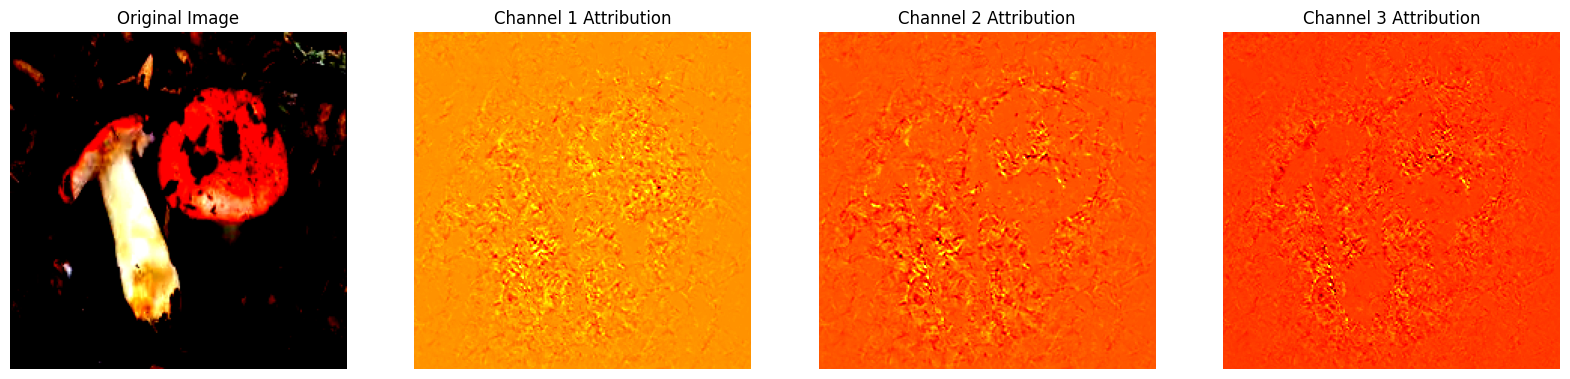

In [ ]:

original_image = image.cpu().numpy().transpose(1, 2, 0) 
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Attribution maps for each channel
for i, ax in enumerate(axes[1:]):
    ax.imshow(attributions[i], cmap='hot')
    ax.set_title(f'Channel {i+1} Attribution')
    ax.axis('off')

plt.show()